<a href="https://colab.research.google.com/github/dancing-with-coffee/ANT6320/blob/master/Copy_of_Copy_of_Copy_of_lesson1_pets_ipynb(320200037_%EA%B9%80%EC%9A%A9%EB%8B%B4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

# Question 1: from fastai.vision import * 문장은 fastai.vision 모듈에 정의되어 있는 모든 클래스와 함수 와 상수들을 
# 임포트하는 것이다. (1.1) 이렇게 임포트한 것들 (이름들, names) 을 모두 나열하라. 
# (1.2) 그 중에서 본 노트북에서 실제로 사용하는 것이 무엇인지 기술하라.
# fastai.vision 모듈은 왼쪽 칼럼에서 네모 아이콘을 클릭하면 개인 사용자의 폴더 구조가 나오는데 여기서 
# /usr/local/lib/python3.6/dist-packages/fastai 폴더 내부에 있고, 
# fastai 내부에서 언급하는 다른 패키지들도 다 dist-packages 안에 존재한다.  
# Import 명령의 작동원리에 대해서는 여기 참조: https://docs.python.org/3/tutorial/modules.html#importing-from-a-package


## Answer 1.
- 1.1

- vision.learner

> cnn_learner, unet_learner, predict, create_body, create_head, from_learner, interpret, plot_top_losses, plot_multi_top_losses

- vision.interpret

> top_losses, _interp_show, show_xyz, _generate_confusion, _plot_intersect_cm

- vision.transform

> get_transforms, zoom_crop, rand_resize_crop, brightness, contrast, crop, crop_pad, dihedral, dihedral_affine, flip_lr, flip_affine, jitter, pad, perspective_warp, resize, rotate, rgb_randomize, skew, squish, symmetric_warp, tilt, zoom, cutout, rand_crop, rand_pad, rand_zoom

- vision.image

> open_image, Image.show, open_mask, open_mask_rle, rle_decode, rle_encode, create, show_image, pil2tensor, image2np, scale_flow, bb2hw, tis2hw, show_all, plot_flat, plot_multi, show_multi, apply_tfms, class Transform, class RandTransform, resolve, class TfmAffine, class TfmCoord, class TfmLightning, class TfmPixel, class TfmCrop, affine, clone, coord, lightning, pixel, refresh, resize, save, class FlowField

- vision.data

> Class ImageDataBunch (from_folder, from_csv, from_df, from_name_re, from_name_func, from_lists, create_from_li, single_from_classes, channel_view, batch_stats, normalize), normalize, denormalize, normalize_funcs, get_annotations, bb_pad_collate, Class ImageList(from_folder, from_csv, from_df, get_Image_files, open, show_xys, show_xyzs), Class ObjectCategoryList, Class ObjectItemList, Class SegmentationItemList, Class SegmentationLabelList, Class PointsLabelList, Class PointsItemList, Class ImageImageList, download_images, verify_images

- vision.gan

> Class GANLearner (from_learners, wgan), Class FixedGANSwitcher(on_train_begin, on_batch_end), Class AdaptiveGANSwitcher(on_batch_end), Class GANDiscriminativeLR(on_batch_begin, on_step_end), basic_critic, basic_generator, gan_critic, Class GANTrainer(switch, on_train_begin, on_epoch_begin, on_batch_begin, on_backward_begin, on_epoch_end, on_train_end), Class GANModule(switch), Class GANLoss, Class AdaptiveLoss(accuracy_thresh_expand), Class NoisyItem, Class GANItemList(show_xys, show_xyzs)

- vision.models

> Class DarkNet, Class WideResNet, Class unet(Class DynamicUnet, Class UnetBlock)



- (1.2) 코드 순서대로 작성합니다. 함수의 혼선이 있을 것 같은 경우에만 class이름을 작성하겠습니다.

> untar_data, get_image_files, ImageDataBunch.from_name_re, show_batch, cnn_learner, fit_one_cycle, save, ClassificationInterpretation.from_learner, ClassificationInterpretation.from_learner.top_losses, ClassificationInterpretation.from_learner.plot_top_losses, ClassificationInterpretation.from_learner.plot_confusion_matrix, ClassificationInterpretation.from_learner.most_confused, unfreeze, load, lr_find, recorder.plot

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
# Question 2: bs 값은 아래에 나오는 명령어 ImageDataBunch.from_name_re() 의 인풋 파라미터 중의 하나이다.
# (2.1) 이 파라미터의 역할이 무엇인지 설명하라. (2.2) 이 값을 증가시킬 때 어떤 일이 일어날 수 있는지 그리고 이 값을 감소 시킬 때 어떤 일이 일어날 수 있는지 설명하라.  

## Answer 2.

- 2.1

> bs 파라미터는 batch_size를 결정해주는 파라미터이다. batch_size란 training에서 feed forward를 한 번 할때 사용하는 데이터의 양이며, 보통 8의 배수를 사용한다.

- 2.2

> batch_size가 줄어들면, GPU memory 사용량이 줄어들지만 학습할 때 update 횟수가 증가하므로 전체적인 계산량이 늘어난다.(동일 epoch 기준) batch_size가 늘어나면 GPU memory의 사용량이 늘어나고 local optima에 빠질 가능성이 올라가지만, 학습할 때 update 횟수가 줄어들고 병렬화를 통해 계산 비용을 많이 줄일 수 있다. 

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [6]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [7]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [8]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [10]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_44.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_81.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_26.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_175.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_49.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
# Question 3: ImageDataBunch.from_name_re() 메소드는 파일 path 로부터 특정 조건을 만족하는 파일들을 찾아서 이를 data 
# 에 집어넣는 일을 한다. 이 data 는 신경망 학습에 사용될 것이므로, 이를 잘 준비하는 것은 매우 중요한 일이다. 
# 위 문장은 data = ImageDataBunch.methodA().methodB() 의 모양을 가지고 있다. 이것은 ImageDataBunch.methodA()  에 생성된 
# object 에 methodB() 를 적용하여 object 를 생성하고 이것을 data 에 할당하라는 뜻이다.(3.1)  methodA가 하는 일을 상세하기 기술하라. 
# methodA는 많은 인풋 파라미터를 가지고 있는데, 이를 고려하여 하는 일을 기술하라. docs.fast.ai 를 참고하라. 
# (3.2) 그리고 methodB (normalize) 가 하는 일도 기술하라. 특히 이 메소드의 인풋 파라미터인 imagenet_stats 를 언급하면서 
# 하는 일을 기술하라.                                  

## Answer 3.

- 3.1

> methodA() = from_name_re

> method prototype : from_name_re( path : PathOrStr, fnames: FilePathList, pat: str, valid_pct: float=0.2, **kwargs)

> from_name_re method는 path에서 fnames의 이름을 가지는 파일들중에 pat(regular expression)을 만족하는 파일들을 불러오는 함수이다. valid_pct를 입력하면 이 중에 입력한 Percent만큼을 validation set으로 사용하게 된다.

> 현재 코드에서 사용된 예제를 해석해보면, /root/.fastai/data/oxford-iiit-pet/images 폴더안에 있는 jpg 파일들중에서, 영문_영문_숫자.jpg로 되어있는 이미지를 모두 읽어와서 get_transform() 함수를 이용해 data augmentation을 한뒤, 224x224 사이즈로 이미지의 크기를 정하고, batch_size만큼씩 학습에 사용할 수 있게 세팅한다.

- 3.2

> normalization 함수는 모든 이미지 벡터를 mean을 빼고, std를 나눠서 zero-centered 되게 만든다. 이러한 과정을 정규화한다. ImageNet style의 dataset 데이터셋에서 정규화를 진행할때 imagenet_stats를 사용할 수 있다.

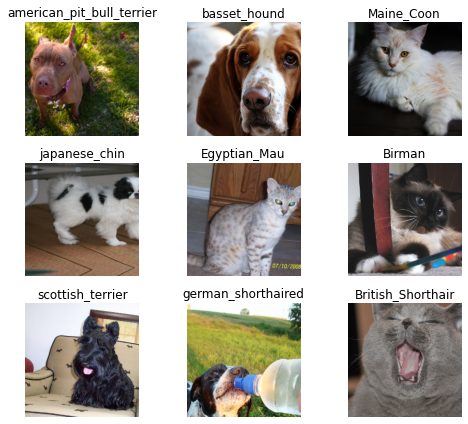

In [13]:
data.show_batch(rows=3, figsize=(7,6))

In [14]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# Question 4: cnn_learner() 는 함수이다. 파이선에서 함수라는 말은 어느 클래스에도 속하지 않고 독립적으로 존재하는 object
# 라는 뜻이다. ( 파이선 언어에서는 그 언어에 등장하는 모든 것 (모든 이름) 이 다 object 이다. 즉 클래스의 인스턴스도 object이고
# 함수도 object이고 integer 도 object이다. Integer가 object 라는 그 안에 이런 저런 관련된 메소드들의 미리 정의되어 있다는 뜻이다.
# 클래스에 속하는 함수는 메소드라고 구분하여 부른다.)
#  4.1) cnn_learner 는 다음과 같이 정의되어 있는 함수이다. 
#def cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int,Callable]=None, 
# pretrained:bool=True, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, 
# custom_head:Optional[nn.Module]=None, split_on:Optional[SplitFuncOrIdxList]=None, 
# bn_final:bool=False, init=nn.init.kaiming_normal_, concat_pool:bool=True, **kwargs:Any)->Learner:
#    "Build convnet style learner."
#    meta = cnn_config(base_arch)
#    model = create_cnn_model(base_arch, data.c, cut, pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
#        bn_final=bn_final, concat_pool=concat_pool)
#    learn = Learner(data, model, **kwargs)
#    learn.split(split_on or meta['split'])
#    if pretrained: learn.freeze()
#    if init: apply_init(model[1], init)
#    return learn

# 참고: 
#Learner(data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None,
#        metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, 
#        wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', 
#        callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, 
#        layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None)

# Learner = Trainer for model using data to minimize loss_func with optimizer opt_func.
# ==> Learner 크클스에 의해 생성된 object "learn" (  learn = Learner(data, model, **kwargs) )은 
# 신경망을 학습시키는 (신경망의 weight 파라미터를 학습시키는) 프로그램을 내장하고 있는 object 이다. 
# 이 object 의 특정 method 들을 실행시키는 과정을 통해서 실제로 신경망이 학습된다. 
# 즉 프로그래머는 학습을 시키는 프로그램 을 구성하는 단계 와 그 프로그램을 실행하여 
# 실제로 신경망을 학습시키는 단계를 구분하여 일을 수행한다. 
  
#  cnn_learner 함수와 Learner 클래스가 어느 어느 패키지의 어느 모듈에 정의되어 있는지 확인하라. 
# (4.2) cnn_learner 는 cnn 신경망을 학습시키는 러너 오브젝트를 구성할 때 3개의 인풋 파라미터만 명시적으로 지정했다.
# 지정하지 않은 파라미터는 default 값을 사용하게 된다. 파라미터 뒤에 = 기호가 나오면 그 뒤에 나오는 값이
# default 값이다. 파라미터 중 하나가 pretained:bool = true 인데 이것이 의미하는 바가 무엇인지 설명하라.  만약 
# (4.3) learn = cnn_learner(data, models.resnet34, pretained = false, metrics=error_rate) 
# 를 사용하면 어떤 일이 일어나는지 설명하라.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## Answer 4.

- 4.1

> cnn_learner 함수는 vision.learner 패키지에 들어있으며, Learner Class는 basic_train 패키지에 들어있다.

- 4.2

> pretrained값이 True로 세팅되면 해당 model(여기서는 resnet34)의 마지막 레이어만 unfreeze를 하여 학습 시킨다. (실제 실행되는건 self.freeze_to(-1))

- 4.3

> pretrained를 False로 하면 모든 레이어가 unfreeze되며, 모든 레이어의 weight를 Learner 클래스가 생성한 Learn object가 data를 통해 학습하게 된다. 이 때 error_rate를 metric으로 주면 학습의 평가를 accuracy로 하게 된다.

In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
learn.fit_one_cycle(4)
# Question 5: (5.1) 이 문장을 실행하면 어떤 일이 수행되는가? 인풋 파라미터 4 는 무엇을 의미하는가?
#(5.2) 이 문장을 실행하면 아래와 같이 epoch 별로 train_loss, valid_loss, error_rate 값이 찍히는데, 
#각 값의 의미가 무엇인지 설명하라.

epoch,train_loss,valid_loss,error_rate,time
0,1.387160,0.306075,0.098782,01:32
1,0.631876,0.260570,0.092693,01:32
2,0.386636,0.231850,0.071719,01:32
3,0.279542,0.217572,0.066306,01:31


## Answer 5.

- 5.1

> learn object를 학습시키게 된다. 이 때 parameter 4는 epoch를 얘기하며, 이는 data 전체를 4번 학습시킨다는 의미이다.

- 5.2

> loss란, 학습 결과가 정답과 얼마나 달랐는지는 평가하는 값이다.

> train_loss는 training data로 training을 마치고 나오는 loss값.

> valid_loss는 validation data로 test했을 때 나오는 loss값.

> error_rate는 1 - accuracy 이며, 이는 모든 정답을 다 맞았을때 0, 다 틀리면 1로 표시된다. 낮을 수록 학습이 잘되었다는 의미이다.

In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

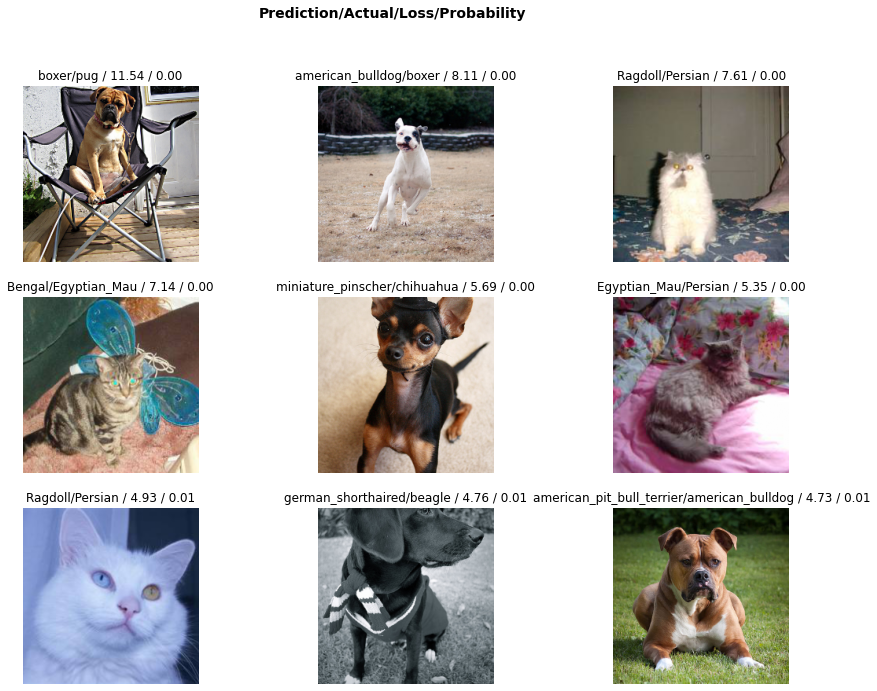

In [22]:
interp.plot_top_losses(9, figsize=(15,11))
# Question 6: 본 노트북에서 학습시키고 실행시키는 신경망은 주어진 인풋 이미지를 분류하는 
# 즉 인풋이미지에 대해서 37 개의 카테고리에 속할 확률을 계산해주는 신경망이다.
#  interp = ClassificationInterpretation.from_learner(learn)
# 는 이 분류 (Classification) 을 해석 (Interpretation) 하는데 사용할 object "interp" 를 생성한다.  
# (6.1) 37 개의 category가 무엇인지 적절한 명령을 실행하여 프린트하라. 
# (6.2) interp.plot_top_losses(9, figsize=(15,11)) 명령어가 하는 일이 무엇인지 대략 기술하라
# (6.3) 아래 그림을 보면 디스플레이된 이미지 위에 두개의 이름과 2개의 값이 기술되어 있다. 이 기술은
# 아래에 디스플레이 되어 있는 이미지의 성격을 기술할 텐데, 각 기술이 해당 이미지에 대해서 말하는 바를 설명하라.
# 9개의 경우에 대해서 다 설명한다 

## Answer 6.

- 6.1

> 바로 상단의 출력 결과. set(interp.ds.y)

- 6.2

> interp.plot_top_losses(9, figsize=(15, 11))는 학습 결과 predict loss가 가장 높게 나오는 데이터를 9개 square 모양으로 (15, 11)size의 figure에 출력한다.

- 6.3

> 설명의 편의를 위해 왼쪽 위 -> 오른쪽 아래 순서대로 1 ~ 9번 그림으로 명명하겠습니다.

> 1번 그림 : pug class 사진인데, boxer class로 predict하였고, 그 때의 loss는 11.54이며 실제 class라고 예측한 확률은 0.00

> 2번 그림 : boxer class 사진인데, american_bulldog class로 predict하였고, 그 때의 loss는 8.11이며 실제 class라고 예측한 확률은 0.00

> 3번 그림 : Persian class 사진인데, Ragdoll class로 predict하였고, 그 때의 loss는 7.61이며 실제 class라고 예측한 확률은 0.00

> 4번 그림 : Egyptian_Mau class 사진인데, Bengal class로 predict하였고, 그 때의 loss는 7.14이며 실제 class라고 예측한 확률은 0.00

> 5번 그림 : chihuahua class 사진인데, miniature_pinscher class로 predict하였고, 그 때의 loss는 5.69이며 실제 class라고 예측한 확률은 0.00

> 6번 그림 : Persian class 사진인데, Egyptian_Mau라고 Predict하였고, 그 때의 loss는 5.35이며 실제 class라고 예측한 확률은 0.00

> 7번 그림 : Persian class 사진인데, Ragdoll라고 Predict하였고, 그 때의 loss는 4.93이며 실제 class라고 예측한 확률은 0.01

> 8번 그림 : beagle 사진인데, german_shorthaired라고 Predict하였고, 그 때의 loss는 4.76이며 실제 class라고 예측한 확률은 0.01

> 9번 그림 : american_bulldog class 사진인데, american_pit_bull_terrier라고 Predict하였고, 그 때의 loss는 4.73이며 실제 class라고 예측한 확률은 0.01





In [29]:
# Answer 6.1
set(interp.ds.y)

{Category Abyssinian,
 Category Bengal,
 Category Birman,
 Category Bombay,
 Category British_Shorthair,
 Category Egyptian_Mau,
 Category Maine_Coon,
 Category Persian,
 Category Ragdoll,
 Category Russian_Blue,
 Category Siamese,
 Category Sphynx,
 Category american_bulldog,
 Category american_pit_bull_terrier,
 Category basset_hound,
 Category beagle,
 Category boxer,
 Category chihuahua,
 Category english_cocker_spaniel,
 Category english_setter,
 Category german_shorthaired,
 Category great_pyrenees,
 Category havanese,
 Category japanese_chin,
 Category keeshond,
 Category leonberger,
 Category miniature_pinscher,
 Category newfoundland,
 Category pomeranian,
 Category pug,
 Category saint_bernard,
 Category samoyed,
 Category scottish_terrier,
 Category shiba_inu,
 Category staffordshire_bull_terrier,
 Category wheaten_terrier,
 Category yorkshire_terrier}

In [23]:
doc(interp.plot_top_losses)

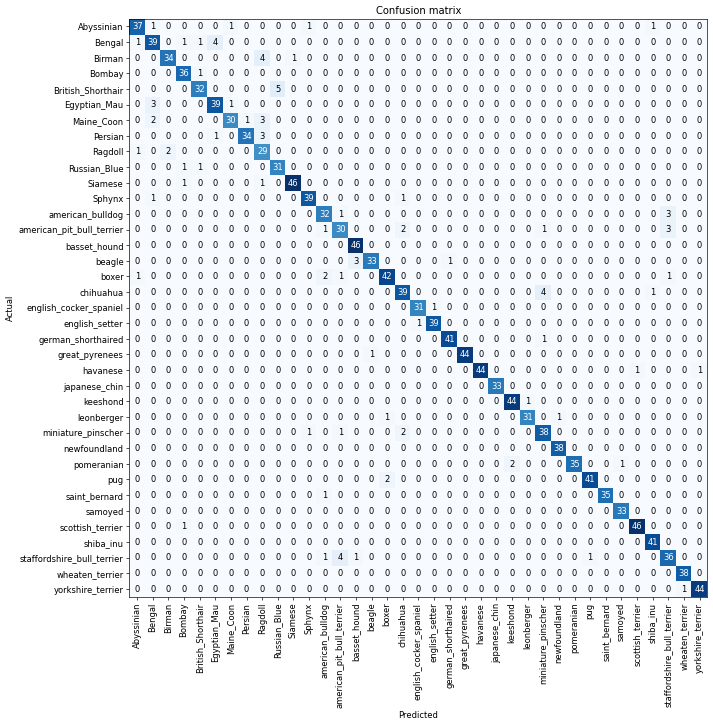

In [30]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
# Question 7: 이 명령어는 아래 그림에 보는 것 처럼 confusion matrix 라는 것을 프린트하는데, 이 confusion matrix 는
# 본 신경망이 주어진 이미지를 37개의 카테코리로 얼마나 잘 분류하는지를 전체적으로 보여주는 표이다. 아래 표를 해석하여
# 할 줄 알아야 본 신경망을 제대로 사용한다고 할 수 있다. 아래 표를 해석하고 설명하라. 

## Answer 7.

> Confusion matrix를 C 라고하면, C[i][j]는 모든 데이터에 대해 i번째 actual class, j번째 predicted class에 해당하는 갯수이다. i는 actual class의 종류(37가지), j는 predicted class의 종류(37가지)가 되며, i == j이면 맞게 예측한 경우의 데이터 수가 된다.

> plot_confusion_matrix library에서는 맞은 케이스 (diagonal) 원소를 파란색 표시를 통해 표현하였고, 갯수가 많은 것을 의미한다. diagonal이 아닌 원소들은 전부 다르게 예측한 경우이며 이를 통해 어떤 클래스를 어떤 클래스로 잘못 예측했는지 쉽게 파악할 수 있다.

> 지금의 예제에서는 Bengal을 Egyptian_Mau로 4개 잘못 예측하였고, miniature_pinscher를 chihuahua로 4개 잘못 예측한 경우가 된다.

In [31]:
interp.most_confused(min_val=2)
# Question 8: 이 문장은 8개의 값을 프린트하는데 이들 값이 어떤 종류의 값인지 설명하라.

[('British_Shorthair', 'Russian_Blue', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Birman', 'Ragdoll', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Persian', 'Ragdoll', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('beagle', 'basset_hound', 3),
 ('Maine_Coon', 'Bengal', 2),
 ('Ragdoll', 'Birman', 2),
 ('american_pit_bull_terrier', 'chihuahua', 2),
 ('boxer', 'american_bulldog', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('pomeranian', 'keeshond', 2),
 ('pug', 'boxer', 2)]

## Answer 8.

> confusion matrix의 diagonal이 아닌 경우중에서 값이 가장 높은 케이스를 출력한다. 지금 예제의 경우 Brithis_Shorthair를 Russian_Blue로 5개 잘못 예측하였다는 의미가 되며, 먼저 출력되는것이 가장 많이 틀린 케이스이고, min_val=2로 세팅이 되었기 때문에 최소 2개 이상 틀린 경우에 대해서 출력을 한다. 현재 학습 결과에선 이게 8가지이다. (저의 출력결과는 19개)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(1)
# Question 9: 윗 문장들은 신경망을 수정가능한 모드로 바꾸고 (unfreeze) 다시 학습을 시켰는데, 도대체 무엇을 어떻게 
# 학습시켰는가?

epoch,train_loss,valid_loss,error_rate,time
0,0.691173,0.413158,0.123816,01:35


## Answer 9.

> learn.unfreeze()는 위에서 학습시킨 모델(resnet34) 전체를 다시 학습할 수 있게 된다. 지금 코드에서는 기존에 학습되어 있는 모델에 추가로 1 epoch를 학습시킨것이 된다. 데이터와 모델을 그대로 이용하며 이는 Learn Object를 생성할 때 기술되어 있는 정도를 그대로 가져와서 사용한다.

In [0]:
learn.load('stage-1');

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


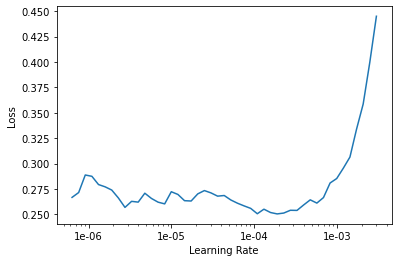

In [36]:
learn.recorder.plot()
# Question 10: 학습 레이트 (lr = learning rate) 가 가로축에 나타나고 loss 가 세로축에 나타난 그래프이다. 
#(10.1) 여기서 learning rate 라는 것이 무엇인지 설명하라. 
#(10.2) loss 가 무엇인지 설명하라. 
#(10.3) 다음 그래프는 무엇을 말하고 있는가?

## Answer 10.

- 10.1

> learning_rate는 각 step마다 update를 하는 weight값이며, 이는 gradient를 얼마나 update할 것인지를 결정하게 되는 hyperparameter이다.

- 10.2

> loss는 training data로 학습을 할 때, 해당 learning rate를 지정하여 계산한 Loss값이며, 이는 epoch를 진행하면서 어느정도 수렴을 하게되면 자동으로 넘어간다.

- 10.3

> 그래프를 보고 해당 learn object에서는 어떤 learning rate일 때 최저 training loss를 가지는지 알 수 있으며, 대략 0.00001일때 minimum loss를 가진다. learning rate가 0.0001보다 커지면 Loss가 엄청나게 커지는 것을 알 수 있는데 이는 loss function이 학습시 수렴하지 못하고 발산하기 때문이다.

In [37]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
# Question 11: (11.1) 윗 문장을 learning rate 를 수정했는데, 이것의 의미는 무엇인가? 
#(11.2) 러닝 레이트를 수정한 결과 무엇이 바뀌었는가?

epoch,train_loss,valid_loss,error_rate,time
0,0.255532,0.218573,0.071042,01:37
1,0.216824,0.209242,0.068336,01:36


## Answer 11. 

- 11.1

> 학습할 때 사용하는 learning rate의 범위를 1e-6에서부터 1e-4까지 사이로 지정하였으며 이는 위에 나온 recorder.plot()에서 loss가 낮았던 범위이다.

- 11.2

> 좋은 LR을 세팅하게 되면 train_loss, valid_loss, error_rate가 모두 줄어드는 것을 확인할 수 있다. 바로 위의 결과와 비교하자면, train_loss가 0.691173에서 0.216824로 엄청나게 떨어진 것을 확인할 수 있고 error_rate 또한 0.123816에서 0.068336으로 떨어진 것을 확인할 수 있다.

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


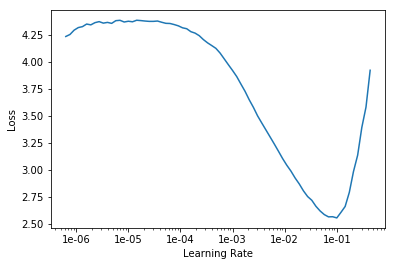

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

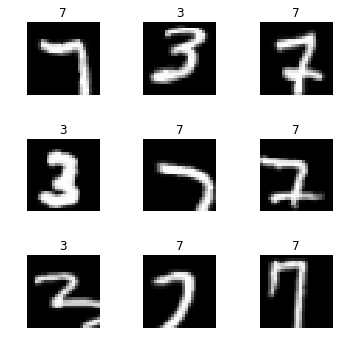

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

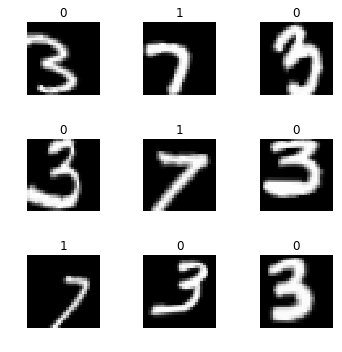

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']